In [1]:
# install RDKit for offline use
!pip install /kaggle/input/rdkit-install-whl/rdkit_wheel/rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/rdkit-install-whl/rdkit_wheel/rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors

from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 2. Helper functions
def compute_descriptors(smiles_series):
    """Compute 3D inertia, TPSA, MR, and Gasteiger charge stats."""
    cols = ('inertia_sum','inertia_ratio','TPSA','MR','chg_mean','chg_std')
    records = []
    for smi in smiles_series:
        m = Chem.AddHs(Chem.MolFromSmiles(smi))
        if AllChem.EmbedMolecule(m, randomSeed=42) != 0:
            vals = [np.nan]*6
        else:
            AllChem.UFFOptimizeMolecule(m, confId=0)
            I1 = rdMolDescriptors.CalcPMI1(m)
            I2 = rdMolDescriptors.CalcPMI2(m)
            I3 = rdMolDescriptors.CalcPMI3(m)
            vals = [
                I1+I2+I3,
                I1/(I2+1e-6),
                rdMolDescriptors.CalcTPSA(m),
                Descriptors.MolMR(m)
            ]
            AllChem.ComputeGasteigerCharges(m)
            ch = [float(a.GetProp('_GasteigerCharge')) for a in m.GetAtoms()]
            vals += [np.mean(ch), np.std(ch)]
        records.append(dict(zip(cols, vals)))
    return pd.DataFrame.from_records(records)


# --- Utility function to create grid from random best params
def create_grid_from_best(best_params, steps=3, percent=0.3):
    grid = {}
    for k, v in best_params.items():
        if isinstance(v, (int, float)):
            low = v * (1 - percent)
            high = v * (1 + percent)
            if isinstance(v, int):
                grid[k] = list(set([int(round(x)) for x in np.linspace(low, high, steps)]))
            else:
                grid[k] = np.linspace(low, high, steps)
        else:
            grid[k] = [v]
    return grid

In [4]:
# 3. Load & prepare data
df = pd.read_csv('/kaggle/input/dataset-9may/dataset_9May.csv')
smiles = df.pop('Molecule')

# Compute and append descriptors
desc_df = compute_descriptors(smiles)
df = pd.concat([df, desc_df], axis=1)

# Define targets
targets = ['gap','mu','alpha','homo','lumo','r2','zpve','U0','U','H','G','Cv']

# Define features — **EXCLUDE all targets explicitly!**
features = [c for c in df.columns if c not in targets + ['Molecule']]

# Rebuild feature matrix without leakage
X = df[features].fillna(0)
Y = df[targets]

# Sanity check — should print empty set
print("Targets in features (should be empty):", set(targets).intersection(set(X.columns)))

# Train/test split stratified by molecule size
atoms = [c for c in df.columns if len(c)==1 and c.isupper()]
size = df[atoms].sum(axis=1)
X_tr, X_te, Y_tr, Y_te = train_test_split(
    X, Y, test_size=0.2, random_state=42,
    stratify=pd.qcut(size, 5)
)

# Log transform for mu and r2 - training and test
Y_tr[['mu', 'r2']] = np.log1p(Y_tr[['mu', 'r2']])

Targets in features (should be empty): set()


In [6]:
# --- Preprocessing pipeline
pre = Pipeline([
    ('scale', StandardScaler()),
    ('var', VarianceThreshold(1e-5))
])

# --- Store predictions and models
preds = pd.DataFrame(index=X_te.index, columns=Y_tr.columns)
best_models = {}

# --- Ridge for U0, U, H, G
pipe_ridge = Pipeline([('pre', pre), ('model', MultiOutputRegressor(Ridge()))])
pg_ridge = {'model__estimator__alpha': [0.001, 0.01, 0.1, 1, 10]}

gs_ridge = GridSearchCV(
    pipe_ridge, pg_ridge,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1
)
gs_ridge.fit(X_tr, Y_tr[['U0', 'U', 'H', 'G']])

# Show best parameters
print(f"\n🔍 Ridge (U0, U, H, G) best params: {gs_ridge.best_params_}")

best_models['energies'] = gs_ridge
preds[['U0', 'U', 'H', 'G']] = gs_ridge.predict(X_te)


# --- Settings for random search
pipe_rf = Pipeline([('pre', pre), ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])
pd_rf = {
    'model__n_estimators': randint(100, 600),
    'model__max_depth': randint(5, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': uniform(0.3, 0.7)
}

pipe_hgbr = Pipeline([('pre', pre), ('model', HistGradientBoostingRegressor(random_state=42))])
pd_hgbr = {
    'model__max_iter': randint(300, 800),
    'model__learning_rate': uniform(0.01, 0.15),
    'model__max_depth': randint(4, 12),
    'model__l2_regularization': uniform(0, 0.5)
}

# --- RF targets
for t in ['gap', 'mu', 'homo', 'lumo', 'r2']:
    print(f"\n🔍 {t.upper()} - Random Forest")
    rs = RandomizedSearchCV(pipe_rf, pd_rf, n_iter=20, cv=3, scoring='neg_root_mean_squared_error',
                            n_jobs=-1, random_state=42)
    rs.fit(X_tr, Y_tr[t])
    print(f"  🔧 Best (Random): {rs.best_params_}")
    
    grid = create_grid_from_best(rs.best_params_, steps=3)
    gs = GridSearchCV(pipe_rf, grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    gs.fit(X_tr, Y_tr[t])
    best_models[t] = gs

    pred = gs.predict(X_te)
    preds[t] = np.expm1(pred) if t in ['mu', 'r2'] else pred

    print(f"  🎯 Best (Grid): {gs.best_params_}")

# --- HGBR targets
for t in ['alpha', 'zpve', 'Cv']:
    print(f"\n🔍 {t.upper()} - HGBR")
    rs = RandomizedSearchCV(pipe_hgbr, pd_hgbr, n_iter=30, cv=3, scoring='neg_root_mean_squared_error',
                            n_jobs=-1, random_state=42)
    rs.fit(X_tr, Y_tr[t])
    print(f"  🔧 Best (Random): {rs.best_params_}")
    
    grid = create_grid_from_best(rs.best_params_, steps=3)
    gs = GridSearchCV(pipe_hgbr, grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    gs.fit(X_tr, Y_tr[t])
    best_models[t] = gs
    preds[t] = gs.predict(X_te)

    print(f"  🎯 Best (Grid): {gs.best_params_}")


🔍 Ridge (U0, U, H, G) best params: {'model__estimator__alpha': 0.01}

🔍 GAP - Random Forest
  🔧 Best (Random): {'model__max_depth': 17, 'model__max_features': 0.8832364382153151, 'model__min_samples_leaf': 3, 'model__n_estimators': 305}
  🎯 Best (Grid): {'model__max_depth': 22, 'model__max_features': 0.6182655067507205, 'model__min_samples_leaf': 2, 'model__n_estimators': 214}

🔍 MU - Random Forest
  🔧 Best (Random): {'model__max_depth': 17, 'model__max_features': 0.4899443222417271, 'model__min_samples_leaf': 5, 'model__n_estimators': 379}
  🎯 Best (Grid): {'model__max_depth': 22, 'model__max_features': 0.4899443222417271, 'model__min_samples_leaf': 4, 'model__n_estimators': 265}

🔍 HOMO - Random Forest
  🔧 Best (Random): {'model__max_depth': 17, 'model__max_features': 0.8832364382153151, 'model__min_samples_leaf': 3, 'model__n_estimators': 305}
  🎯 Best (Grid): {'model__max_depth': 22, 'model__max_features': 0.6182655067507205, 'model__min_samples_leaf': 2, 'model__n_estimators': 39

In [7]:
# --- Evaluation
print('Model Evaluation By Parameter:')
for t in Y_tr.columns:
    rmse = np.sqrt(mean_squared_error(Y_te[t], preds[t]))
    mae = mean_absolute_error(Y_te[t], preds[t])
    r2val = r2_score(Y_te[t], preds[t])
    print(f"{t:>6}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2val:.4f}")

Model Evaluation By Parameter:
   gap: RMSE=0.0184, MAE=0.0126, R2=0.8430
    mu: RMSE=1.0061, MAE=0.6728, R2=0.5742
 alpha: RMSE=1.3001, MAE=0.8174, R2=0.9633
  homo: RMSE=0.0102, MAE=0.0070, R2=0.8114
  lumo: RMSE=0.0161, MAE=0.0108, R2=0.8737
    r2: RMSE=79.2523, MAE=48.1949, R2=0.8945
  zpve: RMSE=0.0049, MAE=0.0031, R2=0.9752
    U0: RMSE=0.7115, MAE=0.5284, R2=0.9994
     U: RMSE=0.7110, MAE=0.5281, R2=0.9994
     H: RMSE=0.7110, MAE=0.5281, R2=0.9994
     G: RMSE=0.7119, MAE=0.5287, R2=0.9994
    Cv: RMSE=0.9643, MAE=0.7251, R2=0.9209


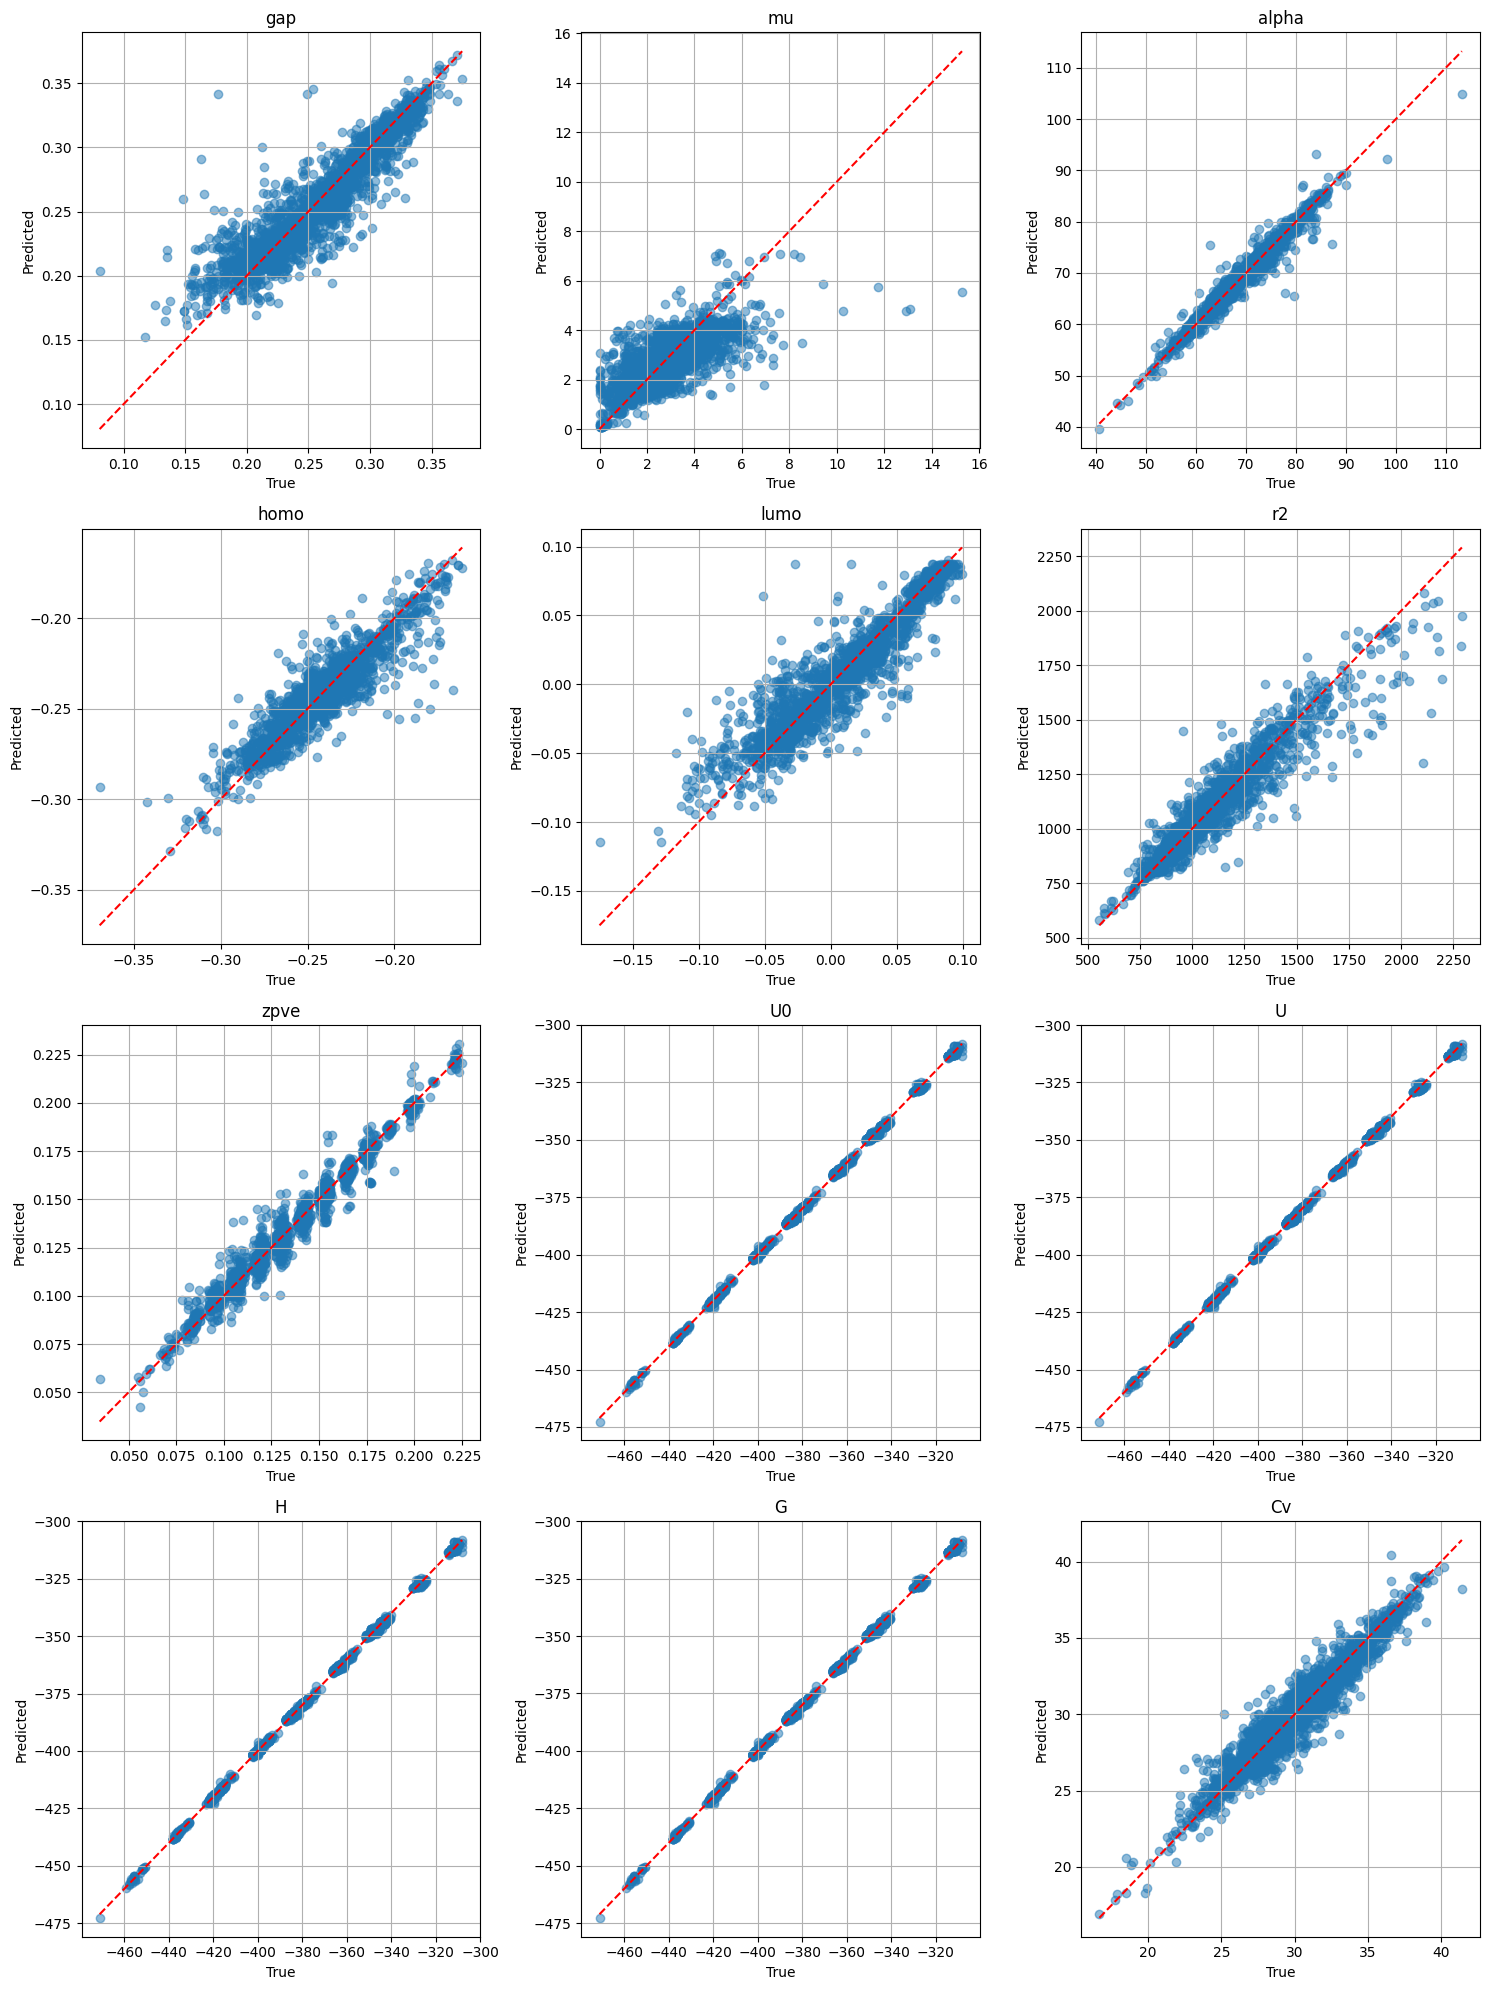

In [8]:
# List of target property names
col_names = Y_te.columns.tolist()

# Number of subplot rows and columns
cols = 3
rows = int(np.ceil(len(col_names) / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axes array for iteration
for i, ax in enumerate(axes.flat):
    if i < len(col_names):
        true_vals = Y_te[col_names[i]].values
        pred_vals = preds[col_names[i]].values

        ax.scatter(true_vals, pred_vals, alpha=0.5)
        ax.plot([true_vals.min(), true_vals.max()],
                [true_vals.min(), true_vals.max()], 'r--')
        ax.set_title(f"{col_names[i]}")
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.grid(True)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

🔍 SHAP analysis for: gap


PermutationExplainer explainer: 301it [02:50,  1.69it/s]                         


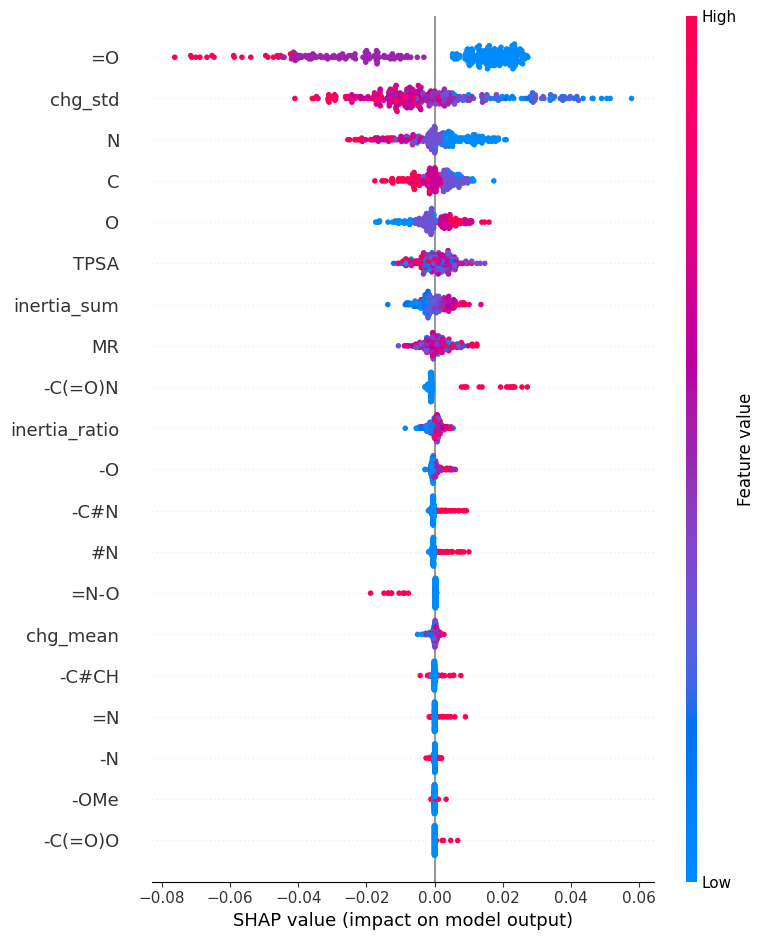

🔍 SHAP analysis for: mu


PermutationExplainer explainer: 301it [03:17,  1.44it/s]                         


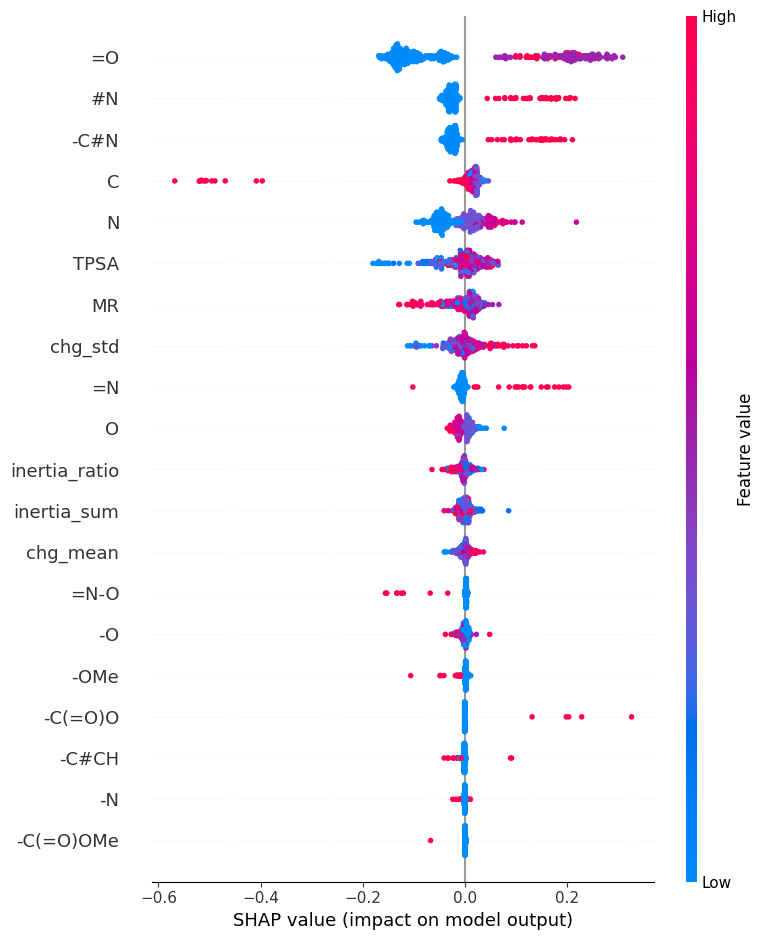

🔍 SHAP analysis for: alpha


PermutationExplainer explainer: 301it [04:07,  1.16it/s]                         


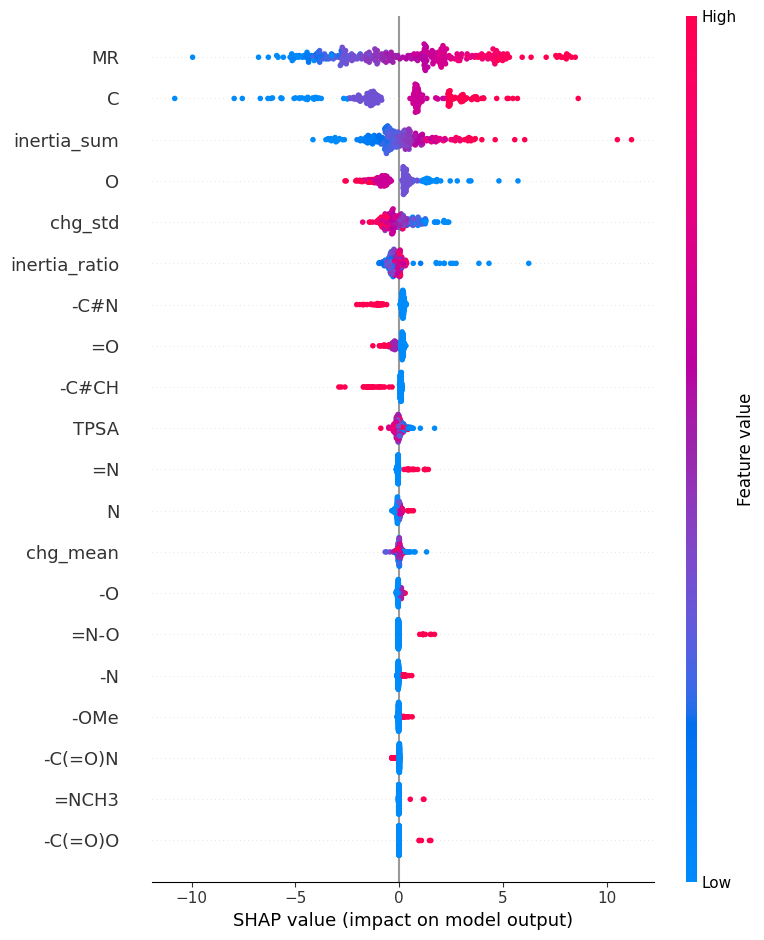

🔍 SHAP analysis for: homo


PermutationExplainer explainer: 301it [04:50,  1.00s/it]                         


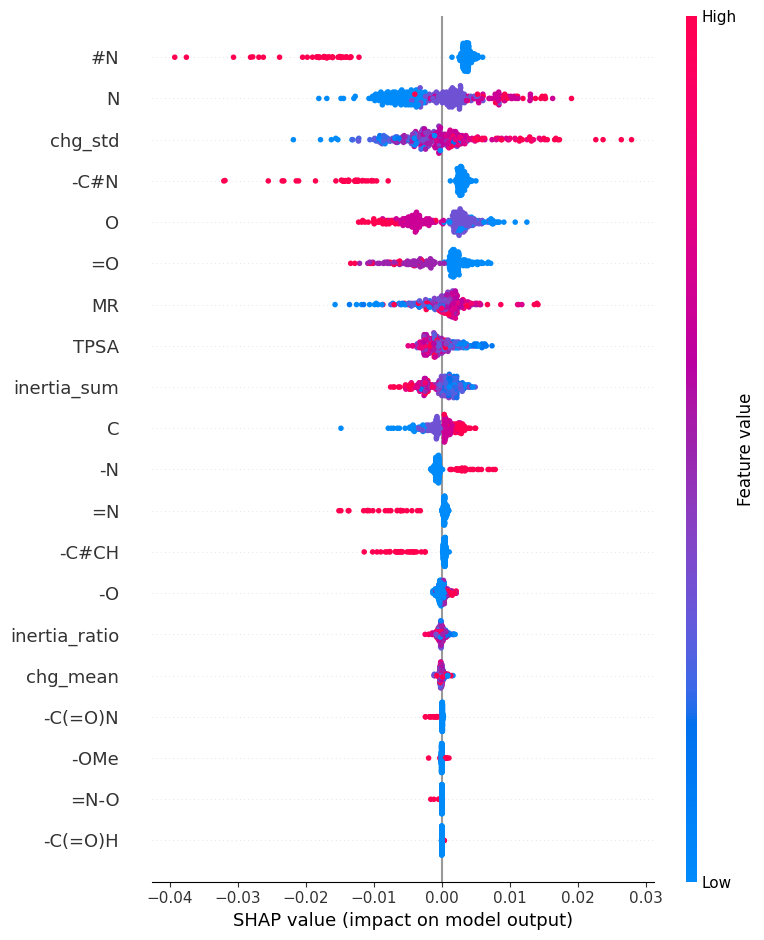

🔍 SHAP analysis for: lumo


PermutationExplainer explainer: 301it [04:53,  1.01s/it]                         


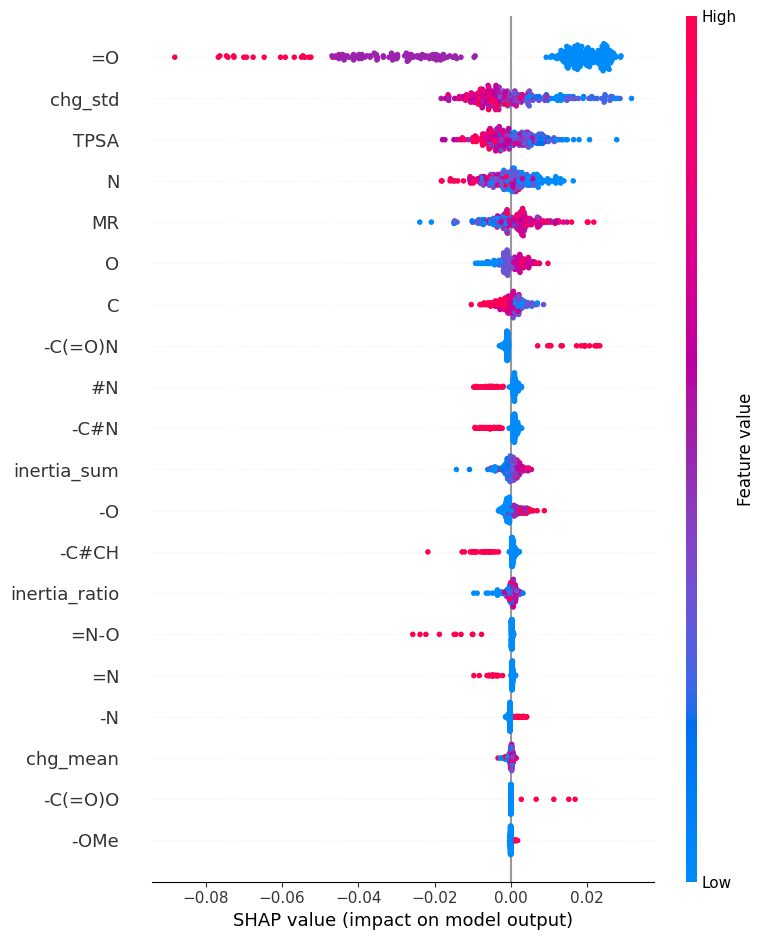

🔍 SHAP analysis for: r2


PermutationExplainer explainer: 301it [05:53,  1.21s/it]                         


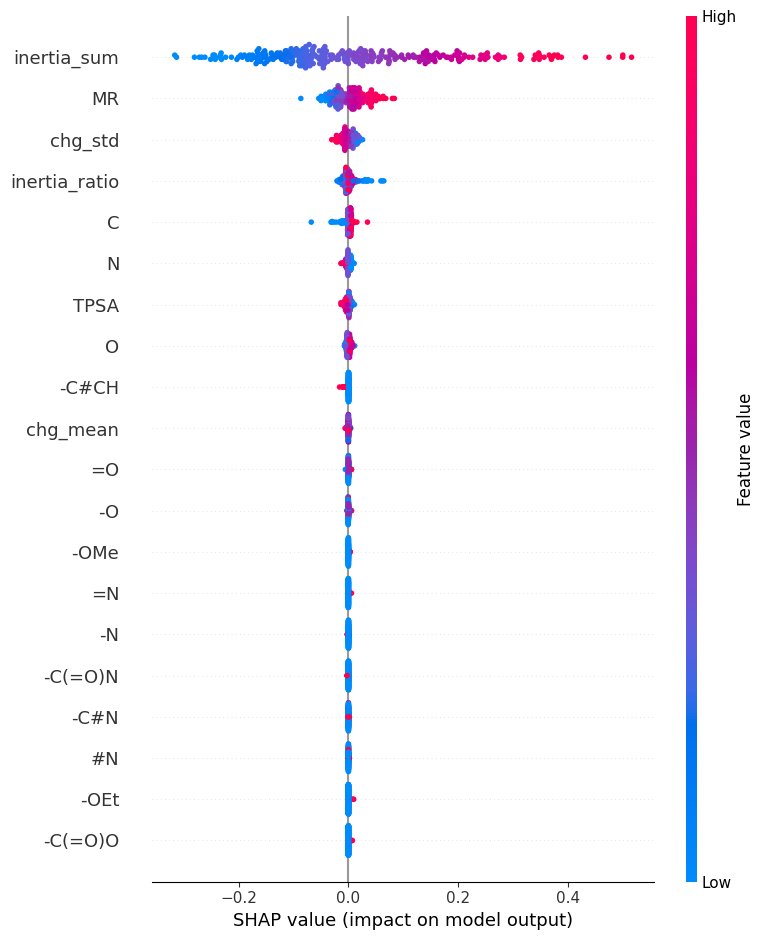

🔍 SHAP analysis for: zpve


PermutationExplainer explainer: 301it [04:31,  1.07it/s]                         


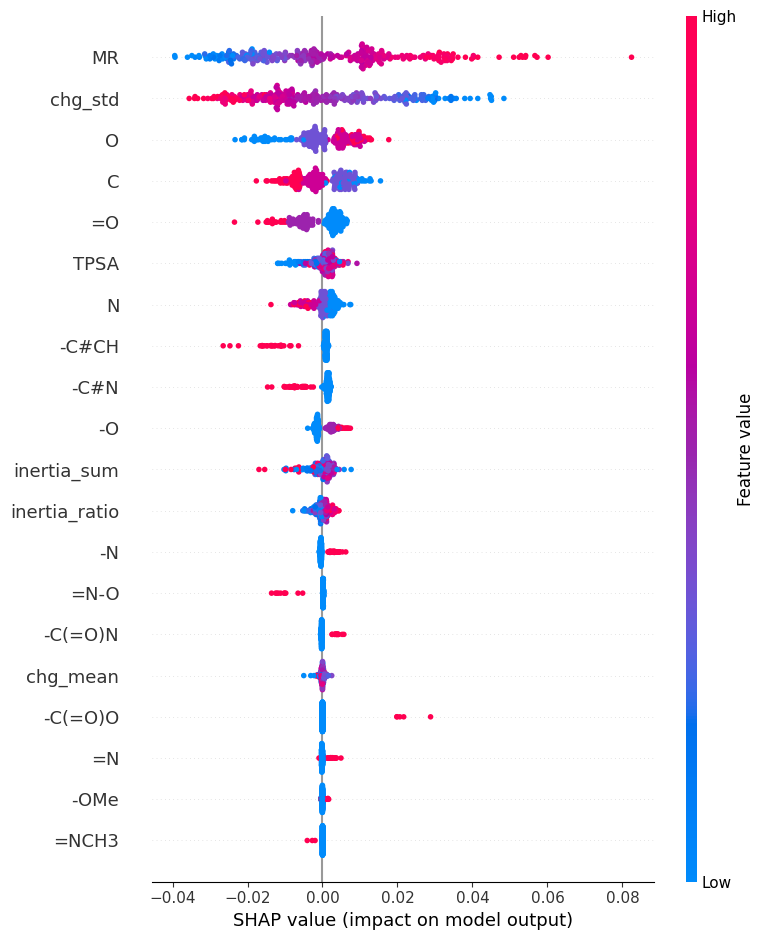

🔍 SHAP analysis for: U0


  0%|          | 0/300 [00:00<?, ?it/s]

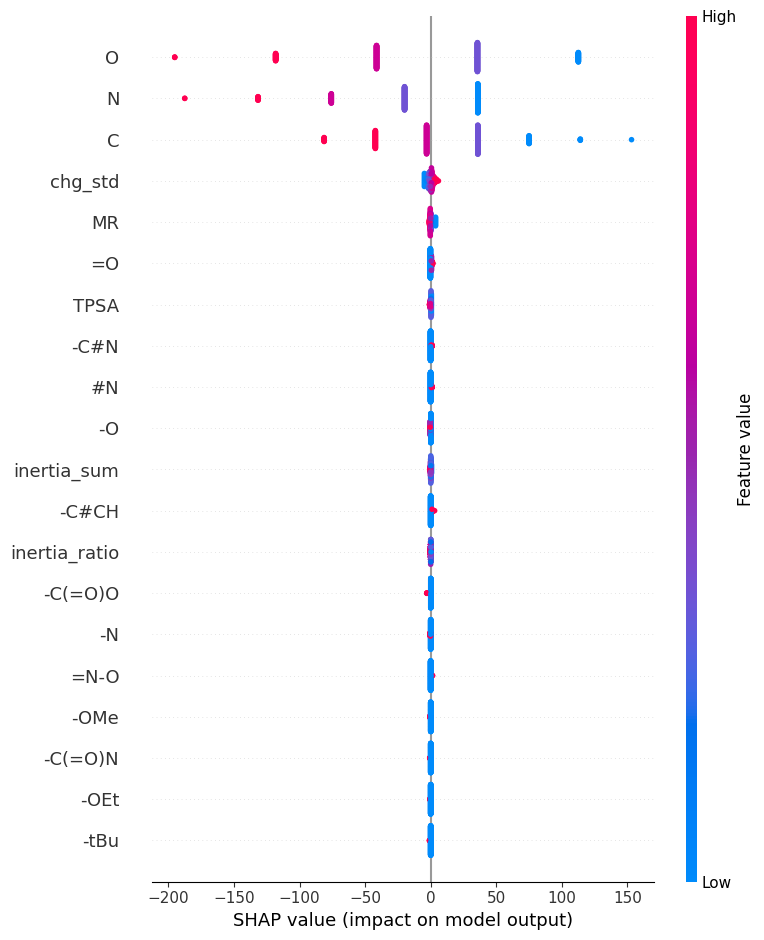

🔍 SHAP analysis for: U


  0%|          | 0/300 [00:00<?, ?it/s]

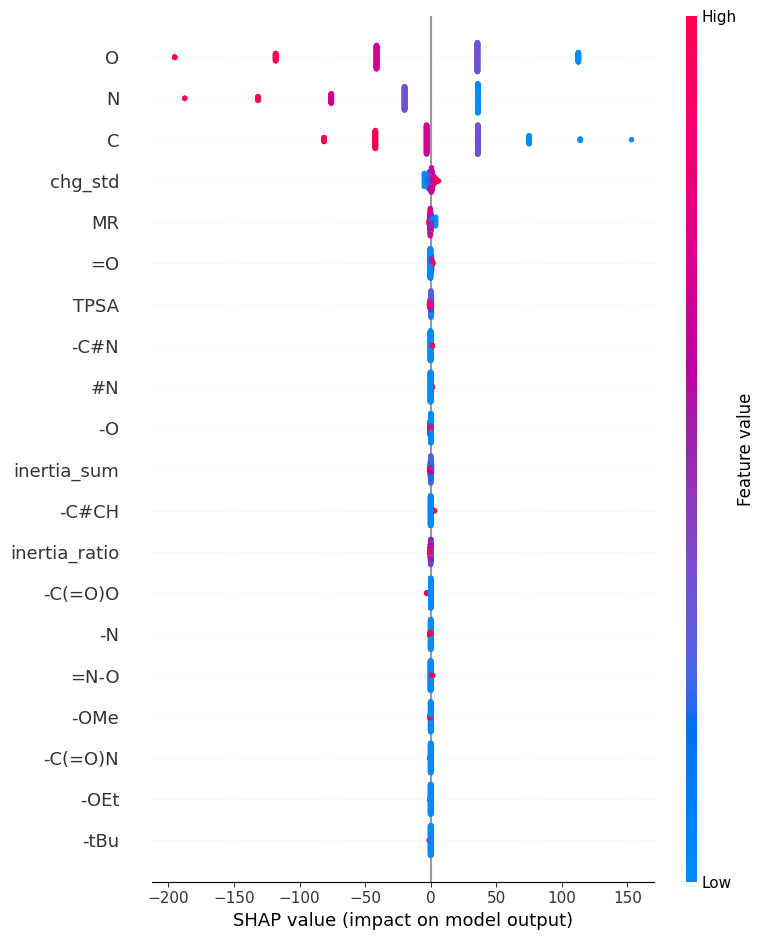

🔍 SHAP analysis for: H


  0%|          | 0/300 [00:00<?, ?it/s]

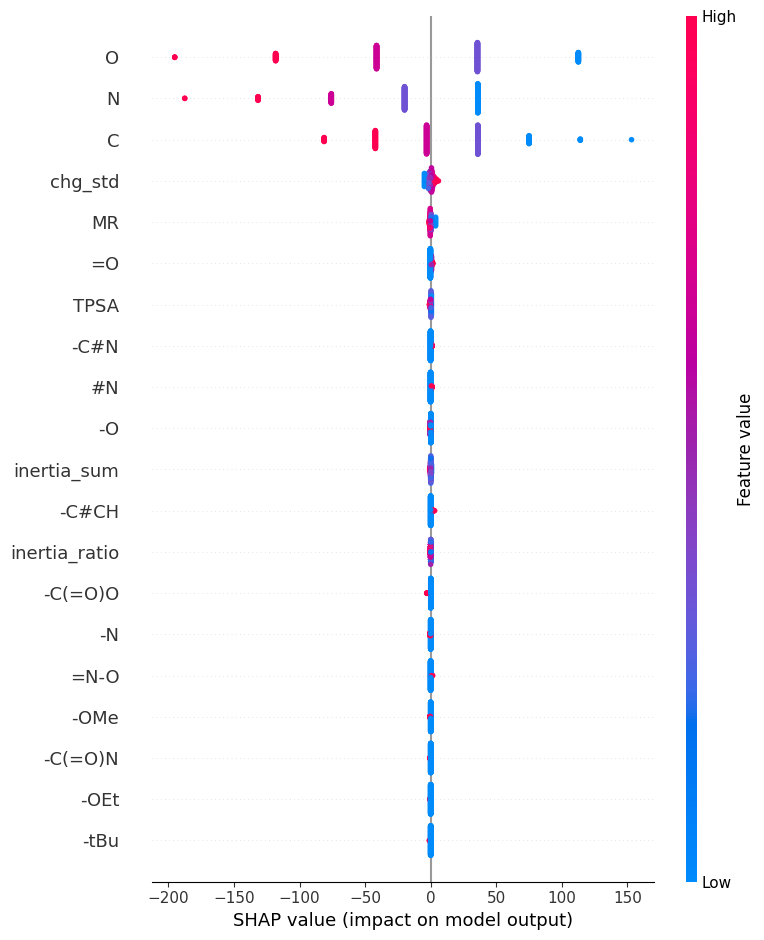

🔍 SHAP analysis for: G


  0%|          | 0/300 [00:00<?, ?it/s]

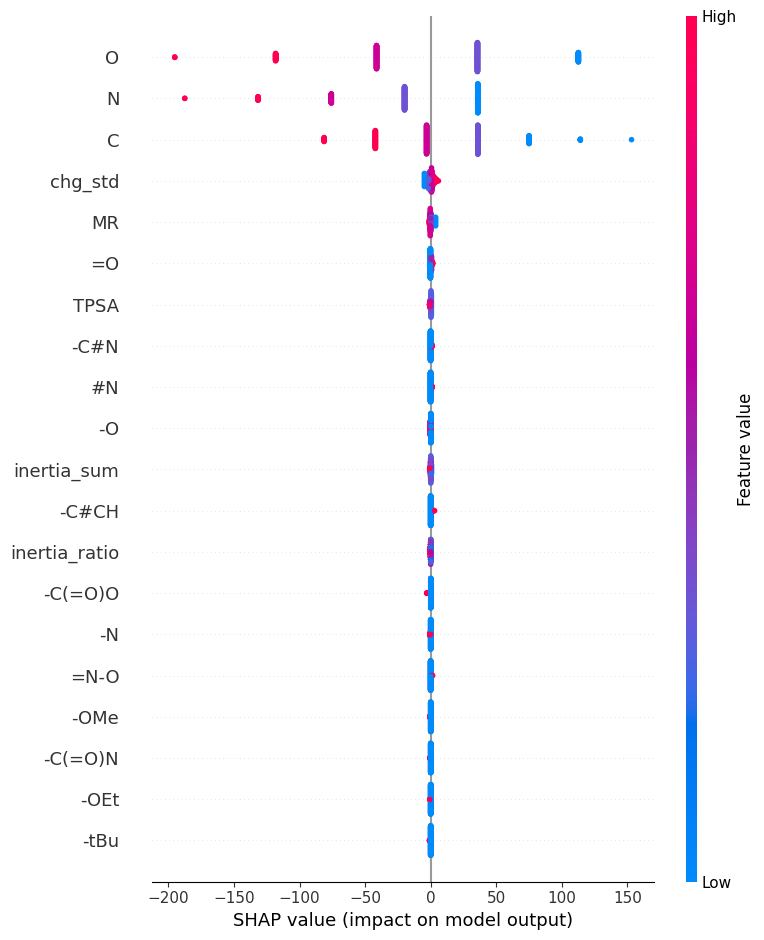

🔍 SHAP analysis for: Cv


PermutationExplainer explainer: 301it [04:44,  1.02it/s]                         


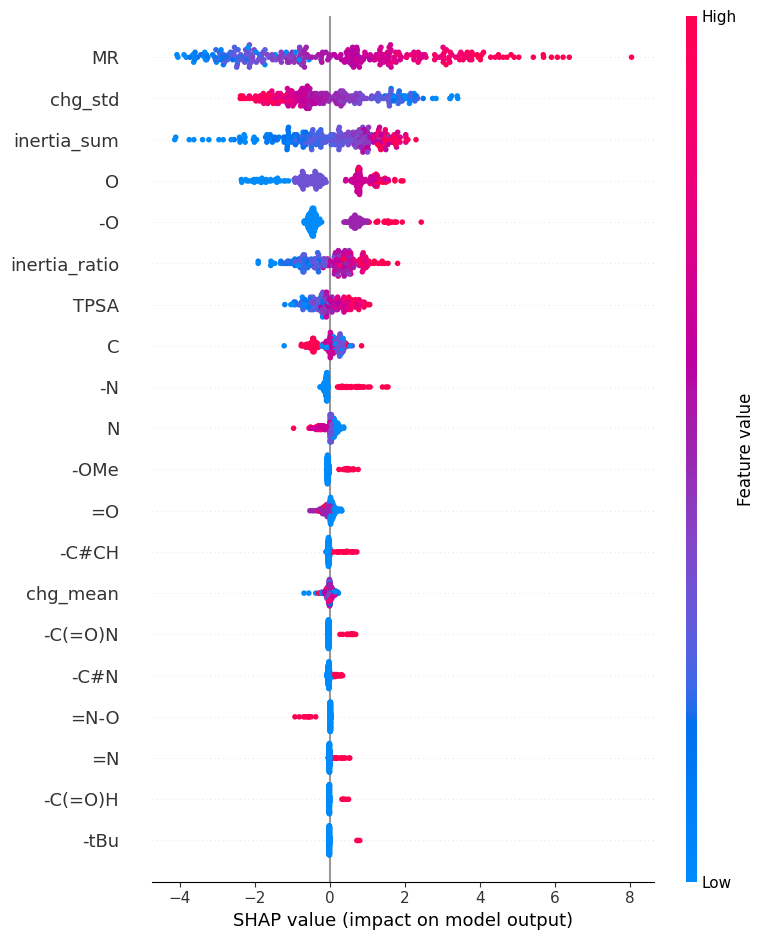

In [9]:
import shap

# Select the appropriate SHAP explainer based on model type
def get_shap_explainer(model, X_sample):
    if isinstance(model, (RandomForestRegressor, HistGradientBoostingRegressor)):
        return shap.Explainer(model.predict, X_sample)  # TreeExplainer via callable
    elif isinstance(model, Ridge):
        return shap.KernelExplainer(model.predict, shap.kmeans(X_sample, 10))
    elif hasattr(model, 'estimator') and isinstance(model.estimator, Ridge):  # for MultiOutputRegressor
        return shap.KernelExplainer(lambda x: model.predict(x), shap.kmeans(X_sample, 10))
    else:
        raise ValueError("Model type not supported for SHAP")

# Limit sample size for performance (adjust as needed)
X_sample = X_te.sample(n=300, random_state=42) if len(X_te) > 300 else X_te

# Loop through each target
for target in Y_tr.columns:
    print(f"🔍 SHAP analysis for: {target}")

    model = best_models[target] if target in best_models else best_models['energies']  # MultiOutputRegressor for U0-U-H-G
    if target in ['U0', 'U', 'H', 'G']:  # slice appropriate estimator
        idx = ['U0', 'U', 'H', 'G'].index(target)
        model = model.best_estimator_.named_steps['model'].estimators_[idx]
        preproc = model_ridge_pre = best_models['energies'].best_estimator_.named_steps['pre']
        X_input = preproc.transform(X_sample)
    else:
        model_pipe = model.best_estimator_
        preproc = model_pipe.named_steps['pre']
        regressor = model_pipe.named_steps['model']
        X_input = preproc.transform(X_sample)
        model = regressor

    try:
        explainer = get_shap_explainer(model, X_input)
        shap_values = explainer(X_input)

        # Plot SHAP summary
        shap.summary_plot(shap_values, X_input, feature_names=X_te.columns.tolist(), show=True)
    except Exception as e:
        print(f"⚠️ Could not compute SHAP for {target}: {e}")
